# Lab 06: Code introspection and metaprogramming
In this lab we are first going to inspect some tooling to help you understand what Julia does under the hood such as:
- looking at the code at different levels
- understanding what method is being called
- showing different levels of code optimization

Secondly we will start playing with the metaprogramming side of Julia, mainly covering:
- how to view abstract syntax tree (AST) of Julia code
- how to manipulate AST

These topics will be extended in the next lecture/lab, where we are going use metaprogramming to manipulate code with macros.

We will be again a little getting ahead of ourselves as we are going to use quite a few macros, which will be properly explained in the next lecture as well, however for now the important thing to know is that a macro is just a special function, that accepts as an argument Julia code, which it can modify.

## Quick reminder of introspection tooling
Let's start with the topic of code inspection, e.g. we may ask the following: What happens when Julia evaluates `[i for i in 1:10]`?
#### parsing 

In [1]:
using Pkg; Pkg.activate("../") # Project in inteactive_notebooks

  Activating new project at `c:\Users\peter\Documents\Skola\SPJ`


In [2]:
using InteractiveUtils

In [3]:
:([i for i in 1:10]) |> dump

Expr
  head: Symbol comprehension
  args: Array{Any}((1,))
    1: Expr
      head: Symbol generator
      args: Array{Any}((2,))
        1: Symbol i
        2: Expr
          head: Symbol =
          args: Array{Any}((2,))
            1: Symbol i
            2: Expr
              head: Symbol call
              args: Array{Any}((3,))
                1: Symbol :
                2: Int64 1
                3: Int64 10


#### lowering

In [4]:
Meta.@lower [i for i in 1:10]

:($(Expr(:thunk, CodeInfo(
    @ none within `top-level scope`
1 ─ %1 = 1:10
│   %2 = Base.Generator(Base.identity, %1)
│   %3 = Base.collect(%2)
└──      return %3
))))

#### typing

In [6]:
f() = [i for i in 1:10]
@code_typed debuginfo=:none f()

CodeInfo(
1 ──       goto #3 if not true
2 ──       nothing::Nothing
3 ┄─ %3  = $(Expr(:foreigncall, :(:jl_alloc_array_1d), Vector{Int64}, svec(Any, Int64), 0, :(:ccall), Vector{Int64}, 10, 10))::Vector{Int64}
└───       Base.arrayset(true, %3, 1, 1)::Vector{Int64}
4 ┄─ %5  = φ (#3 => 2, #13 => %23)::Int64
│    %6  = φ (#3 => 1, #13 => %15)::Int64
└───       goto #14 if not true
5 ── %8  = (%6 === 10)::Bool
└───       goto #7 if not %8
6 ──       goto #8
7 ── %11 = Base.add_int(%6, 1)::Int64
└───       goto #8
8 ┄─ %13 = φ (#6 => true, #7 => false)::Bool
│    %14 = φ (#7 => %11)::Int64
│    %15 = φ (#7 => %11)::Int64
└───       goto #10 if not %13
9 ──       goto #11
10 ─       goto #11
11 ┄ %19 = φ (#9 => true, #10 => false)::Bool
└───       goto #13 if not %19
12 ─       goto #14
13 ─       Base.arrayset(false, %3, %14, %5)::Vector{Int64}
│    %23 = Base.add_int(%5, 1)::Int64
└───       goto #4
14 ┄       goto #15
15 ─       goto #16
16 ─       goto #17
17 ─       return %3
) => Vect

In [7]:
@code_typed optimize=false f()

CodeInfo(
1 ─ %1 = (1:10)::Core.Const(1:10)
│   %2 = Base.Generator(Base.identity, %1)::Core.Const(Base.Generator{UnitRange{Int64}, typeof(identity)}(identity, 1:10))
│   %3 = Base.collect(%2)::Vector{Int64}
└──      return %3
) => Vector{Int64}

#### LLVM code generation

In [8]:
@code_llvm debuginfo=:none f()

; Function Attrs: uwtable
define nonnull {}* @julia_f_1915() #0 {
top:
  %0 = call nonnull {}* inttoptr (i64 140736243116080 to {}* ({}*, i64)*)({}* inttoptr (i64 140733797798624 to {}*), i64 10)
  %1 = bitcast {}* %0 to { i8*, i64, i16, i16, i32 }*
  %arraylen_ptr = getelementptr inbounds { i8*, i64, i16, i16, i32 }, { i8*, i64, i16, i16, i32 }* %1, i64 0, i32 1
  %arraylen = load i64, i64* %arraylen_ptr, align 8
  %inbounds.not = icmp eq i64 %arraylen, 0
  br i1 %inbounds.not, label %oob, label %idxend

oob:                                              ; preds = %top
  %errorbox = alloca i64, align 8
  store i64 1, i64* %errorbox, align 8
  call void @ijl_bounds_error_ints({}* %0, i64* nonnull %errorbox, i64 1)
  unreachable

idxend:                                           ; preds = %top
  %2 = bitcast {}* %0 to i64**
  %arrayptr8 = load i64*, i64** %2, align 8
  %3 = bitcast i64* %arrayptr8 to <4 x i64>*
  store <4 x i64> <i64 1, i64 2, i64 3, i64 4>, <4 x i64>* %3, align 8
  %4 =

#### native code generation

In [9]:
@code_native debuginfo=:none f()

	.text
	.file	"f"
	.section	.rodata.cst32,"aM",@progbits,32
	.p2align	5                               # -- Begin function julia_f_1950
.LCPI0_0:
	.quad	1                               # 0x1
	.quad	2                               # 0x2
	.quad	3                               # 0x3
	.quad	4                               # 0x4
.LCPI0_1:
	.quad	5                               # 0x5
	.quad	6                               # 0x6
	.quad	7                               # 0x7
	.quad	8                               # 0x8
	.section	.rodata.cst16,"aM",@progbits,16
	.p2align	4
.LCPI0_2:
	.quad	9                               # 0x9
	.quad	10                              # 0xa
	.text
	.globl	julia_f_1950
	.p2align	4, 0x90
	.type	julia_f_1950,@function
julia_f_1950:                           # @julia_f_1950
	.cfi_startproc
# %bb.0:                                # %top
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
	sub	rsp, 32
	movabs	rcx, 1407337977986

Let's see how these tools can help us understand some of Julia's internals on examples from previous labs and lectures.

### Understanding runtime dispatch and type instabilities
We will start with a question: Can we spot internally some difference between type stable/unstable code?

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
Inspect the following two functions using `@code_lowered`, `@code_typed`, `@code_llvm` and `@code_native`.

```julia
x = rand(10^5)
function explicit_len(x)
    length(x)
end
function implicit_len()
    length(x)
end
```

For now do not try to understand the details, but focus on the overall differences such as length of the code.


<div class="alert alert-block alert-warning">
<b>info:</b> "Redirecting `stdout`":

If the output of the method introspection tools is too long you can use a general way of redirecting standard output `stdout` to a file
```julia
open("./llvm_fun.ll", "w") do file
    original_stdout = stdout
    redirect_stdout(file)
    @code_llvm debuginfo=:none fun()
    redirect_stdout(original_stdout)
end
```
In case of `@code_llvm` and `@code_native` there are special options, that allow this out of the box, see help `?` for underlying `code_llvm` and `code_native`. If you don't mind adding dependencies there is also the `@capture_out` from [`Suppressor.jl`](https://github.com/JuliaIO/Suppressor.jl)
</div>


</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [10]:
x = rand(10^5)
function explicit_len(x)
    length(x)
end
function implicit_len()
    length(x)
end

implicit_len (generic function with 1 method)

In [12]:
@code_lowered explicit_len(x)


CodeInfo(
1 ─ %1 = Main.length(x)
└──      return %1
)

In [13]:
@code_lowered implicit_len()

CodeInfo(
1 ─ %1 = Main.length(Main.x)
└──      return %1
)

In [14]:
@code_typed explicit_len(x)

CodeInfo(
1 ─ %1 = Base.arraylen(x)::Int64
└──      return %1
) => Int64

In [15]:
@code_typed implicit_len()

CodeInfo(
1 ─ %1 = Main.x::Any
│   %2 = Main.length(%1)::Any
└──      return %2
) => Any

In [17]:
@code_llvm explicit_len(x)

;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:2 within `explicit_len`
; Function Attrs: uwtable
define i64 @julia_explicit_len_2229({}* noundef nonnull align 16 dereferenceable(40) %0) #0 {
top:
;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:3 within `explicit_len`
; ┌ @ essentials.jl:10 within `length`
   %1 = bitcast {}* %0 to { i8*, i64, i16, i16, i32 }*
   %arraylen_ptr = getelementptr inbounds { i8*, i64, i16, i16, i32 }, { i8*, i64, i16, i16, i32 }* %1, i64 0, i32 1
   %arraylen = load i64, i64* %arraylen_ptr, align 8
   ret i64 %arraylen
; └
}


In [18]:
@code_llvm implicit_len()

;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:5 within `implicit_len`
; Function Attrs: uwtable
define nonnull {}* @julia_implicit_len_2231() #0 {
top:
  %0 = alloca {}*, align 8
  %gcframe2 = alloca [3 x {}*], align 16
  %gcframe2.sub = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe2, i64 0, i64 0
  %1 = bitcast [3 x {}*]* %gcframe2 to i8*
  call void @llvm.memset.p0i8.i64(i8* align 16 %1, i8 0, i64 24, i1 true)
  %2 = call {}*** inttoptr (i64 140736243305216 to {}*** ()*)() #6
;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:6 within `implicit_len`
  %3 = bitcast [3 x {}*]* %gcframe2 to i64*
  store i64 4, i64* %3, align 16
  %4 = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe2, i64 0, i64 1
  %5 = bitcast {}** %4 to {}***
  %6 = load {}**, {}*** %2, align 8
  store {}** %6, {}*** %5, align 8
  %7 = bitcast {}*** %2 to {}***
  store {}** %gcfram

In [19]:
@code_native explicit_len(x)

	.text
	.file	"explicit_len"
	.globl	julia_explicit_len_2235         # -- Begin function julia_explicit_len_2235
	.p2align	4, 0x90
	.type	julia_explicit_len_2235,@function
julia_explicit_len_2235:                # @julia_explicit_len_2235
; ┌ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:2 within `explicit_len`
	.cfi_startproc
# %bb.0:                                # %top
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
; │ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:3 within `explicit_len`
; │┌ @ essentials.jl:10 within `length`
	mov	rax, qword ptr [rcx + 8]
	pop	rbp
	ret
.Lfunc_end0:
	.size	julia_explicit_len_2235, .Lfunc_end0-julia_explicit_len_2235
	.cfi_endproc
; └└
                                        # -- End function
	.section	".note.GNU-stack","",@progbits


In [21]:
open("./native_impl.ll", "w") do file
    original_stdout = stdout
    redirect_stdout(file)
    @code_native implicit_len()
    redirect_stdout(original_stdout)
end

VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x000000000000043c) open, 0 bytes waiting)), VSCodeServer.io_send_callback)

In this case we see that the generated code for such a simple operation is much longer in the type unstable case resulting in longer run times. However in the next example we will see that having longer code is not always a bad thing.

####

### Loop unrolling
In some cases the compiler uses loop unrolling[^1] optimization to speed up loops at the expense of binary size. The result of such optimization is removal of the loop control instructions and rewriting the loop into a repeated sequence of independent statements.

[^1]: [https://en.wikipedia.org/wiki/Loop_unrolling](https://en.wikipedia.org/wiki/Loop\_unrolling)

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Inspect under what conditions does the compiler unroll the for loop in the `polynomial` function from the last [lab](@ref horner).
```julia
function polynomial(a, x)
    accumulator = a[end] * one(x)
    for i in length(a)-1:-1:1
        accumulator = accumulator * x + a[i]
    end
    accumulator  
end
```

Compare the speed of execution with and without loop unrolling.

**HINTS**:
- these kind of optimization are lower level than intermediate language
- loop unrolling is possible when compiler knows the length of the input

</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [22]:
function polynomial(a, x)
    accumulator = a[end] * one(x)
    for i in length(a)-1:-1:1
        accumulator = accumulator * x + a[i]
    end
    accumulator  
end

polynomial (generic function with 1 method)

In [23]:
using Test 
using BenchmarkTools

In [45]:
a = tuple(1.0, 2.0, 3.0, 4.0, 5.0)
x = 0.4
typeof(a)

NTuple{5, Float64}

In [46]:
@code_typed polynomial(a, x)

CodeInfo(
1 ─ %1  = Base.getfield(a, 5, true)::Float64
│   %2  = Base.mul_float(%1, 1.0)::Float64
└──       goto #7 if not true
2 ┄ %4  = φ (#1 => 4, #6 => %15)::Int64
│   %5  = φ (#1 => 4, #6 => %16)::Int64
│   %6  = φ (#1 => %2, #6 => %9)::Float64
│   %7  = Base.mul_float(%6, x)::Float64
│   %8  = Base.getfield(a, %4, true)::Float64
│   %9  = Base.add_float(%7, %8)::Float64
│   %10 = (%5 === 1)::Bool
└──       goto #4 if not %10
3 ─       goto #5
4 ─ %13 = Base.add_int(%5, -1)::Int64
└──       goto #5
5 ┄ %15 = φ (#4 => %13)::Int64
│   %16 = φ (#4 => %13)::Int64
│   %17 = φ (#3 => true, #4 => false)::Bool
│   %18 = Base.not_int(%17)::Bool
└──       goto #7 if not %18
6 ─       goto #2
7 ┄ %21 = φ (#5 => %9, #1 => %2)::Float64
└──       return %21
) => Float64

In [47]:
@code_native polynomial(a, x)

	.text
	.file	"polynomial"
	.globl	julia_polynomial_2927           # -- Begin function julia_polynomial_2927
	.p2align	4, 0x90
	.type	julia_polynomial_2927,@function
julia_polynomial_2927:                  # @julia_polynomial_2927
; ┌ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sZmlsZQ==.jl:1 within `polynomial`
	.cfi_startproc
# %bb.0:                                # %pass.3
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
; │ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sZmlsZQ==.jl:4 within `polynomial`
; │┌ @ float.jl:411 within `*`
	vmulsd	xmm0, xmm1, qword ptr [rcx + 32]
; │└
; │┌ @ float.jl:409 within `+`
	vaddsd	xmm0, xmm0, qword ptr [rcx + 24]
; │└
; │┌ @ float.jl:411 within `*`
	vmulsd	xmm0, xmm0, xmm1
; │└
; │┌ @ float.jl:409 within `+`
	vaddsd	xmm0, xmm0, qword ptr [rcx + 16]
; │└
; │┌ @ float.jl:411 within `*`
	vmulsd	xmm0, x

In [41]:
@benchmark polynomial(a, x)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  22.267 ns … 172.417 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     27.583 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.946 ns ±   3.344 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                    ██▃                                         
  ▁▁▁▁▂▂▂▂▆▇▇▆▃▂▂▃▄▄███▆▆▅▄▅▅▄▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  22.3 ns         Histogram: frequency by time         38.6 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [48]:
a = [1, 2, 3, 4, 5]
typeof(a)

Vector{Int64} (alias for Array{Int64, 1})

In [49]:
@code_typed polynomial(a, x)

CodeInfo(
1 ── %1  = Base.arraysize(a, 1)::Int64
│    %2  = Base.slt_int(%1, 0)::Bool
│    %3  = Core.ifelse(%2, 0, %1)::Int64
│    %4  = Base.arrayref(true, a, %3)::Int64
│    %5  = Base.sitofp(Float64, %4)::Float64
│    %6  = Base.mul_float(%5, 1.0)::Float64
│    %7  = Base.arraylen(a)::Int64
│    %8  = Base.sub_int(%7, 1)::Int64
└───       goto #3 if not true
2 ──       nothing::Nothing
3 ┄─       goto #5
4 ──       nothing::Nothing
5 ┄─ %13 = (1 === %8)::Bool
└───       goto #7 if not %13
6 ──       goto #23
7 ── %16 = Base.slt_int(%8, 1)::Bool
│    %17 = (false === %16)::Bool
│    %18 = Base.not_int(%17)::Bool
└───       goto #12 if not %18
8 ──       goto #10
9 ──       nothing::Nothing
10 ┄ %22 = Base.add_int(%8, 1)::Int64
└───       goto #11
11 ─       goto #23
12 ─ %25 = Base.slt_int(%8, 1)::Bool
└───       goto #14 if not %25
13 ─ %27 = Base.sub_int(1, %8)::Int64
└───       goto #15
14 ─ %29 = Base.sub_int(%8, 1)::Int64
15 ┄ %30 = φ (#13 => %27, #14 => %29)::Int64
│    %31 = 

In [50]:
@code_native polynomial(a, x)

	.text
	.file	"polynomial"
	.globl	julia_polynomial_2929           # -- Begin function julia_polynomial_2929
	.p2align	4, 0x90
	.type	julia_polynomial_2929,@function
julia_polynomial_2929:                  # @julia_polynomial_2929
; ┌ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sZmlsZQ==.jl:1 within `polynomial`
	.cfi_startproc
# %bb.0:                                # %top
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
; │ @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sZmlsZQ==.jl:2 within `polynomial`
; │┌ @ abstractarray.jl:426 within `lastindex`
; ││┌ @ abstractarray.jl:389 within `eachindex`
; │││┌ @ abstractarray.jl:137 within `axes1`
; ││││┌ @ abstractarray.jl:98 within `axes`
; │││││┌ @ array.jl:191 within `size`
	mov	rax, qword ptr [rcx + 8]
; │└└└└└
; │┌ @ essentials.jl:13 within `getindex`
	mov	r8, rax
	sub	r8, 1
	jb	.LBB0_6
# 

In [44]:
@benchmark polynomial(a, x)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  23.370 ns … 81.946 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     27.783 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.589 ns ±  2.432 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                      ▃▆█▇▄▃▁                                  
  ▁▂▂▃▃▅▅▅▆▇▇▄▂▂▂▂▂▃▃▇███████▆▅▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  23.4 ns         Histogram: frequency by time          35 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

####

### Recursion inlining depth
Inlining[^2] is another compiler optimization that allows us to speed up the code by avoiding function calls. Where applicable compiler can replace `f(args)` directly with the function body of `f`, thus removing the need to modify stack to transfer the control flow to a different place. This is yet another optimization that may improve speed at the expense of binary size.

[^2]: [https://en.wikipedia.org/wiki/Inline_expansion](https://en.wikipedia.org/wiki/Inline\_expansion)

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Rewrite the `polynomial` function from the last [lab](@ref horner) using recursion and find the length of the coefficients, at which inlining of the recursive calls stops occurring.

```julia
function polynomial(a, x)
    accumulator = a[end] * one(x)
    for i in length(a)-1:-1:1
        accumulator = accumulator * x + a[i]
    end
    accumulator  
end
```

<div class="alert alert-block alert-warning">
<b>Note:</b> "Splatting/slurping operator `...`"

The operator `...` serves two purposes inside function calls [^3][^4]:
- combines multiple arguments into one

```julia
function printargs(args...)
    println(typeof(args))
    for (i, arg) in enumerate(args)
        println("Arg #$i = $arg")
    end
end
printargs(1, 2, 3)
```
- splits one argument into many different arguments
```julia
function threeargs(a, b, c)
    println("a = $a::$(typeof(a))")
    println("b = $b::$(typeof(b))")
    println("c = $c::$(typeof(c))")
end
threeargs([1,2,3]...) # or with a variable threeargs(x...)
```

[^3]: [https://docs.julialang.org/en/v1/manual/faq/#What-does-the-...-operator-do?](https://docs.julialang.org/en/v1/manual/faq/#What-does-the-...-operator-do?)
[^4]: [https://docs.julialang.org/en/v1/manual/functions/#Varargs-Functions](https://docs.julialang.org/en/v1/manual/functions/#Varargs-Functions)
</div>

**HINTS**:
- define two methods `_polynomial!(ac, x, a...)` and `_polynomial!(ac, x, a)` for the case of ≥2 coefficients and the last coefficient
- use splatting together with range indexing `a[1:end-1]...`
- the correctness can be checked using the built-in `evalpoly`
- recall that these kind of optimization are possible just around the type inference stage
- use container of known length to store the coefficients


</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [52]:
function _polynomial!(ac, x, a...)
    _polynomial!(x * ac + a[end], x, a[1:end-1]...)
end

function _polynomial!(ac, x, a)
    x * ac + a
end

function polynomial(a, x)
    _polynomial!(a[end] * one(x), x, a[1:end-1]...)
end

polynomial (generic function with 1 method)

In [53]:
a = (1, 2, 3, 4, 5, 6)

(1, 2, 3, 4, 5, 6)

In [54]:
@code_llvm polynomial(a, x)

;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:9 within `polynomial`
; Function Attrs: uwtable
define double @julia_polynomial_2992([6 x i64]* nocapture noundef nonnull readonly align 8 dereferenceable(48) %0, double %1) #0 {
top:
;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:10 within `polynomial`
; ┌ @ tuple.jl:31 within `getindex`
   %2 = getelementptr inbounds [6 x i64], [6 x i64]* %0, i64 0, i64 5
; └
; ┌ @ promotion.jl:423 within `*`
; │┌ @ promotion.jl:393 within `promote`
; ││┌ @ promotion.jl:370 within `_promote`
; │││┌ @ number.jl:7 within `convert`
; ││││┌ @ float.jl:159 within `Float64`
       %unbox = load i64, i64* %2, align 8
       %3 = sitofp i64 %unbox to double
; └└└└└
; ┌ @ range.jl:429 within `getindex`
; │┌ @ ntuple.jl:19 within `ntuple`
; ││┌ @ range.jl:429 within `#79`
; │││┌ @ tuple.jl:31 within `getindex`
      %4 = getelementptr inb

In [86]:
a = tuple([i for i in 1:33]...)

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)

In [63]:
@code_llvm polynomial(a, x)

;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:9 within `polynomial`
; Function Attrs: uwtable
define double @julia_polynomial_3151([10 x i64]* nocapture noundef nonnull readonly align 8 dereferenceable(80) %0, double %1) #0 {
top:
;  @ c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:10 within `polynomial`
; ┌ @ tuple.jl:31 within `getindex`
   %2 = getelementptr inbounds [10 x i64], [10 x i64]* %0, i64 0, i64 9
; └
; ┌ @ promotion.jl:423 within `*`
; │┌ @ promotion.jl:393 within `promote`
; ││┌ @ promotion.jl:370 within `_promote`
; │││┌ @ number.jl:7 within `convert`
; ││││┌ @ float.jl:159 within `Float64`
       %unbox = load i64, i64* %2, align 8
       %3 = sitofp i64 %unbox to double
; └└└└└
; ┌ @ range.jl:429 within `getindex`
; │┌ @ ntuple.jl:19 within `ntuple`
; ││┌ @ range.jl:429 within `#79`
; │││┌ @ tuple.jl:31 within `getindex`
      %4 = getelementptr 

In [ ]:
open("./native_poly.ll", "w") do file
    original_stdout = stdout
    redirect_stdout(file)
    @code_native polynomial(a,x)
    redirect_stdout(original_stdout)
end

# 33 is unrolled, 34 is not

VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x000000000000043c) open, 0 bytes waiting)), VSCodeServer.io_send_callback)

####

## AST manipulation: The first steps to metaprogramming
Julia is so called homoiconic language, as it allows the language to reason about its code. This capability is inspired by years of development in other languages such as Lisp, Clojure or Prolog.

There are two easy ways to extract/construct the code structure [^5]
- parsing code stored in string with internal `Meta.parse`

In [88]:
code_parse = Meta.parse("x = 2")    # for single line expressions (additional spaces are ignored)
code_parse_block = Meta.parse("""
begin
    x = 2
    y = 3
    x + y
end
""") # for multiline expressions

quote
    #= none:2 =#
    x = 2
    #= none:3 =#
    y = 3
    #= none:4 =#
    x + y
end

- constructing an expression using `quote ... end` or simple `:()` syntax

In [89]:
code_expr = :(x = 2)    # for single line expressions (additional spaces are ignored)
code_expr_block = quote
    x = 2
    y = 3
    x + y   
end # for multiline expressions

quote
    #= c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:3 =#
    x = 2
    #= c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:4 =#
    y = 3
    #= c:\Users\peter\Documents\Skola\SPJ\cv06\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:5 =#
    x + y
end

Results can be stored into some variables, which we can inspect further.

In [90]:
typeof(code_parse)
dump(code_parse)

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Int64 2


In [91]:
typeof(code_parse_block)
dump(code_parse_block)

Expr
  head: Symbol block
  args: Array{Any}((6,))
    1: LineNumberNode
      line: Int64 2
      file: Symbol none
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol x
        2: Int64 2
    3: LineNumberNode
      line: Int64 3
      file: Symbol none
    4: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol y
        2: Int64 3
    5: LineNumberNode
      line: Int64 4
      file: Symbol none
    6: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Symbol x
        3: Symbol y


The type of both multiline and single line expression is `Expr` with fields `head` and `args`. Notice that `Expr` type is recursive in the `args`, which can store other expressions resulting in a tree structure - abstract syntax tree (AST) - that can be visualized for example with the combination of `GraphRecipes` and `Plots` packages. 


    Updating registry at `C:\Users\peter\.julia\registries\General.toml`
   Resolving package versions...
   Installed GeometryTypes ──── v0.8.5
   Installed OffsetArrays ───── v1.14.1
   Installed Inflate ────────── v0.1.5
   Installed ArnoldiMethod ──── v0.4.0
   Installed GeometryBasics ─── v0.4.11
   Installed IterTools ──────── v1.10.0
   Installed Adapt ──────────── v4.1.1
   Installed Extents ────────── v0.1.4
   Installed NetworkLayout ──── v0.4.7
   Installed StaticArraysCore ─ v1.4.3
   Installed EarCut_jll ─────── v2.2.4+0
   Installed ConstructionBase ─ v1.5.8
   Installed StructArrays ───── v0.6.18
   Installed StaticArrays ───── v1.9.8
   Installed AxisAlgorithms ─── v1.1.0
   Installed Ratios ─────────── v0.4.5
   Installed GraphRecipes ───── v0.5.13
   Installed ChainRulesCore ─── v1.25.0
   Installed GeoInterface ───── v1.3.7
   Installed Interpolations ─── v0.15.1
   Installed WoodburyMatrices ─ v1.0.0
   Installed GeoFormatTypes ─── v0.4.2
   Installed SimpleTraits ─

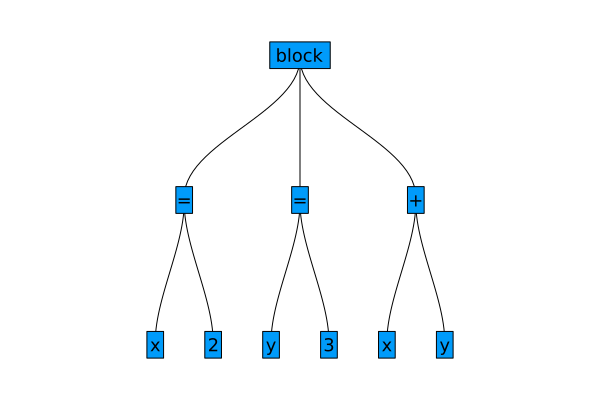

In [94]:
import Pkg; Pkg.add("GraphRecipes")
using GraphRecipes
using Plots
plot(code_expr_block, fontsize=12, shorten=0.01, axis_buffer=0.15, nodeshape=:rect)


This recursive structure has some major performance drawbacks, because the `args` field is of type `Any` and therefore modifications of this expression level AST won't be type stable. Building blocks of expressions are `Symbol`s and literal values (numbers).


A possible nuisance of working with multiline expressions is the presence of `LineNumber` nodes, which can be removed with `Base.remove_linenums!` function.


In [ ]:
Base.remove_linenums!(code_parse_block)

Parsed expressions can be evaluate using `eval` function. 

In [ ]:
eval(code_parse)    # evaluation of :(x = 2) 

In [ ]:
x                   # should be defined

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Before doing anything more fancy let's start with some simple manipulation of ASTs.
- Define a variable `code` to be as the result of parsing the string `"j = i^2"`. 
- Copy code into a variable `code2`. Modify this to replace the power `2` with a power `3`. Make sure that the original code variable is not also modified. 
- Copy `code2` to a variable `code3`. Replace `i` with `i + 1` in `code3`.
- Define a variable `i` with the value `4`. Evaluate the different code expressions using the `eval` function and check the value of the variable `j`.


</div>


<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [ ]:
code = Meta.parse("j = i^2")

:(j = i ^ 2)

In [108]:
code2 = deepcopy(code)
code2.args[2].args[3] = 3
code2

:(j = i ^ 3)

In [ ]:
code3 = deepcopy(code2)
code3.args[2].args[2] = :(i + 1)
code3

:(j = (i + 1) ^ 3)

In [110]:
i = 4

4

In [111]:
eval(code)

16

In [112]:
eval(code2)

64

In [113]:
eval(code3)

125

####
Following up on the more general substitution of variables in an expression from the lecture, let's see how the situation becomes more complicated, when we are dealing with strings instead of a parsed AST.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

```julia
using Test 
replace_i(s::Symbol) = s == :i ? :k : s
replace_i(e::Expr) = Expr(e.head, map(replace_i, e.args)...)
replace_i(u) = u

```
Given a function `replace_i`, which replaces variables `i` for `k` in an expression like the following

```julia
ex = :(i + i*i + y*i - sin(z))
@test replace_i(ex) == :(k + k*k + y*k - sin(z))
```

write a different function `sreplace_i(s)`, which does the same thing but instead of a parsed expression (AST) it manipulates a string, such as

```julia
s = string(ex)
```
**HINTS**:
- Use `Meta.parse` in combination with `replace_i` **ONLY** for checking of correctness.
- You can use the `replace` function in combination with regular expressions.
- Think of some corner cases, that the method may not handle properly.

</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [114]:
replace_i(s::Symbol) = s == :i ? :k : s
replace_i(e::Expr) = Expr(e.head, map(replace_i, e.args)...)
replace_i(u) = u

ex = :(i + i*i + y*i - sin(z))

@test replace_i(ex) == :(k + k*k + y*k - sin(z))

Test Passed

In [115]:
s = string(ex)

"(i + i * i + y * i) - sin(z)"

####

In [119]:
sreplace_i(s::String) = string(replace_i(Meta.parse(s)))

sreplace_i (generic function with 1 method)

In [121]:
sreplace_i(s::String) = replace(s, "i" => "k")

sreplace_i (generic function with 1 method)

In [ ]:
sreplace_i(s)  

"(k + k * k + y * k) - skn(z)"

If the exercises so far did not feel very useful let's focus on one, that is similar to a part of the [`IntervalArithmetics.jl`](https://github.com/JuliaIntervals/IntervalArithmetic.jl) pkg.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Write function `wrap!(ex::Expr)` which wraps literal values (numbers) with a call to `f()`. You can test it on the following example
```julia
f = x -> convert(Float64, x)
ex = :(x*x + 2*y*x + y*y)     # original expression
rex = :(x*x + f(2)*y*x + y*y) # result expression
```

**HINTS**:
- use recursion and multiple dispatch
- dispatch on `::Number` to detect numbers in an expression
- for testing purposes, create a copy of `ex` before mutating

</div>

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

####

In [ ]:
g = x -> convert(Float64, x)
ex = :(x*x + 2*y*x + y*y)     # original expression
rex = :(x*x + g(2)*y*x + y*y) # result expression

####

This kind of manipulation is at the core of some pkgs, such as aforementioned [`IntervalArithmetics.jl`](https://github.com/JuliaIntervals/IntervalArithmetic.jl) where every number is replaced with a narrow interval in order to find some bounds on the result of a computation.


[^5]: Once you understand the recursive structure of expressions, the AST can be constructed manually like any other type.

## Resources
- Julia's manual on [metaprogramming](https://docs.julialang.org/en/v1/manual/metaprogramming/)
- David P. Sanders' [workshop @ JuliaCon 2021](https://www.youtube.com/watch?v=2QLhw6LVaq0) 
- Steven Johnson's [keynote talk @ JuliaCon 2019](https://www.youtube.com/watch?v=mSgXWpvQEHE)
- Andy Ferris's [workshop @ JuliaCon 2018](https://www.youtube.com/watch?v=SeqAQHKLNj4)
- [From Macros to DSL](https://github.com/johnmyleswhite/julia_tutorials) by John Myles White 
- Notes on [JuliaCompilerPlugin](https://hackmd.io/bVhb97Q4QTWeBQw8Rq4IFw?both#Julia-Compiler-Plugin-Project)